In [2]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from ranthymetry import gen_samples
import xrft
!matplotlib inline

/bin/sh: matplotlib: command not found


In [15]:
# Load data #
# ETOPO: /work/gam/ETOPO1/ETOPO1_Ice_g_gmt4.grd
# SRTM topo15: /work/gam/srtm/topo15.grd

filename = '/work/gam/ETOPO1/ETOPO1_Ice_g_gmt4.grd'
ds = xr.open_dataset(filename)
ds = ds.rename({'x':'lon','y':'lat'})

(-20, 10)

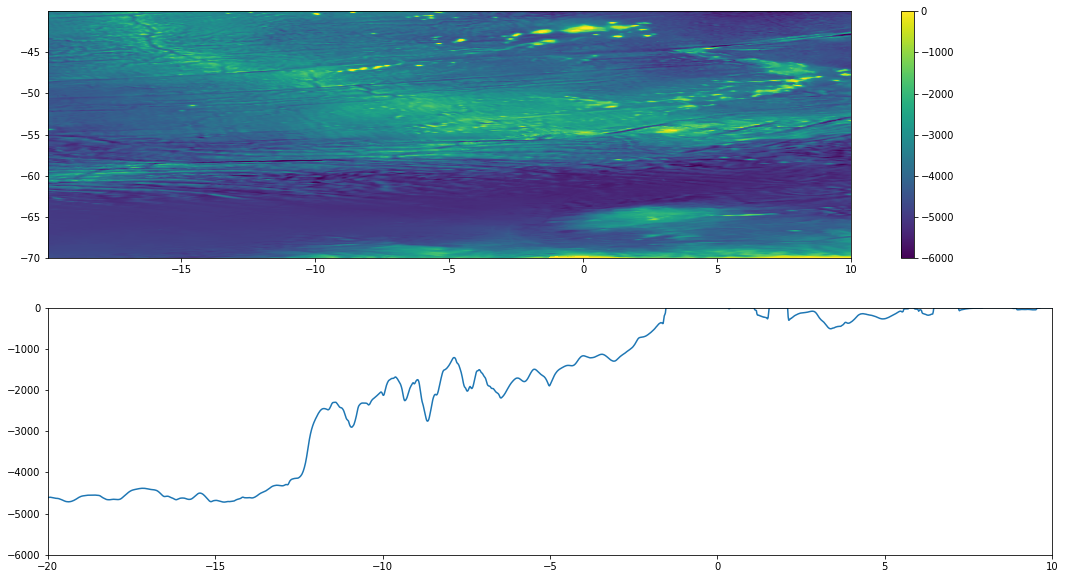

In [31]:
# Select subsection of data
LAT=[-70,-40]
LON=[-20,10]
f = ds.z.sel(lat=slice(LAT[0],LAT[1]),lon=slice(LON[0],LON[1]))
f = xr.where(f>0,0,f)

fig, ax = plt.subplots( 2, 1, figsize=(18,10) )
im = ax[0].pcolormesh(f.lon,f.lat,f.values)
plt.colorbar(im,ax=ax[0])
im.set_clim([-6000,0])
im = ax[1].plot(f.lon,f.values[0,:])
ax[1].set_ylim([-6000,0])
ax[1].set_xlim(LON)

In [89]:
def gen_samples( f, n_samples, apply_hamming=True ) :
    """
    Estimate the 2D power spectrum of the input
    field f, and use random phase sampling to produce
    n_samples of f with the same spectrum of f.
    
    Inputs
    f : 2D array, field to produce samples of
    n_samples : integar, number of samples to generate
    
    Outputs
    samples : 3D array containing the samples of 2D fields
    
    """
    Ny, Nx = f.shape
    
    # applying Hamming window
    if apply_hamming :
        
        w_x = np.hamming(Nx)
        w_y = np.hamming(Ny)
        
        win = np.sqrt( np.outer( w_y, w_x ) )
        
        f *= win
    
    samples = np.zeros( (n_samples,Ny,Nx) )
    samples_spec = np.empty( (n_samples,Ny,Nx) )
    
    # calculate mean and std of f
    f_mean = np.mean(f)
    f_sig = np.std(f)
    
    # remove mean
    f -= f_mean
    
    # 2D power spectrum calculation
    dft = np.fft.fft2(f)            # compute 2D dft
    #dft = np.fft.fftshift( psd )    # shift zero frequency
    
    mod = np.abs(dft)
    
    for i in range(n_samples) :
        
        # generate 2D grid of random phases
        # between 0 and 2pi
        phase_x = np.zeros( Nx )
        phase_y = np.zeros( Ny )
        # In the following, impose zero in first entry of randomised phases
        # Procedure:
            # Randomise entries in phase_* from index 1 to Nx/2
            # (remember in python, index Nx/2 is the entry one greater than the mid-point)
                # e.g. phase_x = [0 1 2 3 4 0 0 0]
            # Take entries 1 to Nx/2, set them to negative, reverse their order,
            # and put them into phase_* in entries Nx/2 to end
                # e.g. phase_x = [0 1 2 3 -4 -3 -2 -1]
            # Note that index Nx/2 is set in the first step and then just reversed in sign
            # For an odd number of entries, the entry in index Nx/2 is set twice...
                # e.g. step 1: phase_x = [0 1 2 3 4 0 0 0 0]
                # then step 2: phase_x = [0 1 2 3 4 -4 -3 -2 -1]
        
        if Nx % 2 == 0 :
            
            phase_x[1:int(Nx/2+1)] = np.random.uniform( size=int(Nx/2) ) * 2 *np.pi
            phase_x[int(Nx/2):] = np.flip(-phase_x[1:int(Nx/2+1)])
            
        else :
            
            phase_x[1:int((Nx-1)/2+1)] = np.random.uniform( size=int( (Nx-1)/2) ) * 2 *np.pi
            phase_x[int((Nx-1)/2+1):] = np.flip(-phase_x[1:int((Nx-1)/2+1)])
            
        if Ny % 2 == 0 :
            
            phase_y[1:int(Ny/2+1)] = np.random.uniform( size=int(Ny/2) ) * 2 *np.pi
            phase_y[int(Ny/2):] = np.flip(-phase_y[1:int(Ny/2+1)])
            
        else :
            
            phase_y[1:int((Ny-1)/2+1)] = np.random.uniform( size=int( (Ny-1)/2) ) * 2 *np.pi
            phase_y[int((Ny-1)/2+1):] = np.flip(-phase_y[1:int((Ny-1)/2+1)])
            
        
        phase_x, phase_y = np.meshgrid( phase_x, phase_y )
            
        # use random phases to construct
        # new 2D sample with same spectrum
        f_spec = mod * np.exp( 1j * phase_x + 1j * phase_y  )
        
        # invert the sample power spectrum
        # and reintroduce mean
        f_sample = np.real( np.fft.ifft2( f_spec ) )
        f_sample += f_mean
        
        # re-scale to variance of original f
        f_sample /= np.std( f_sample )
        f_sample *= f_sig
        
        samples[i,:,:] = f_sample
        samples_spec[i,:,:] = f_spec
        
        
    return samples, samples_spec, dft, phase_x, phase_y

In [97]:
n=1
samples, samples_spec, dft, px, py = gen_samples(-f.values,n_samples=n,apply_hamming=True)

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/ipykernel_launcher.py:99: ComplexWarning: Casting complex values to real discards the imaginary part


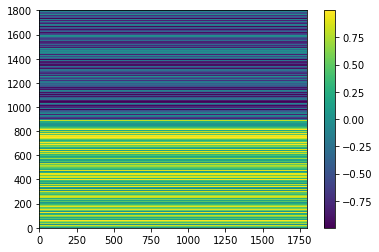

In [98]:
im=plt.pcolormesh(py/(2*np.pi))
plt.colorbar(im)

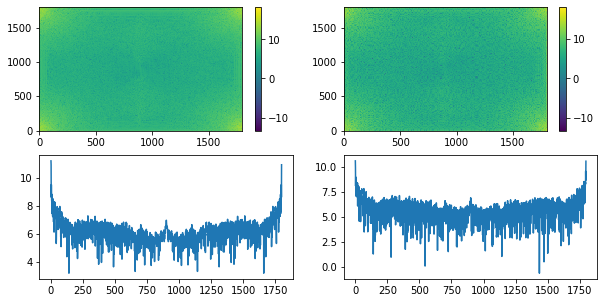

In [99]:
# Plot original dft and randomly generated dft
fig, ax = plt.subplots( 3, 2, figsize=(10,5) )
# Original
im=ax[0,0].pcolormesh(np.log10(np.abs(dft)**2))
plt.colorbar(im,ax=ax[0,0])
im=ax[1,0].plot(np.log10(np.abs(dft[np.int(np.round(dft.shape[0]/2)),:])**2))
# Random
s = samples_spec[0,:,:]
im=ax[0,1].pcolormesh(np.log10(np.abs(s)**2))
plt.colorbar(im,ax=ax[0,1])
im=ax[1,1].plot(np.log10(np.abs(s[np.int(np.round(s.shape[0]/2)),:])**2))

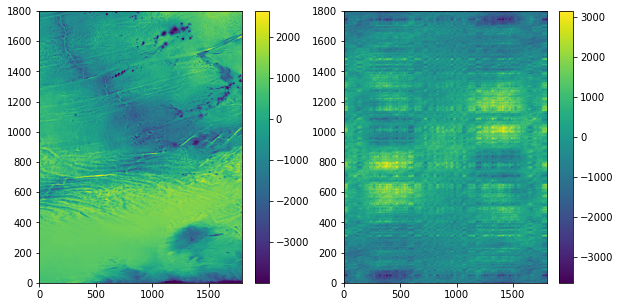

In [88]:
# Take inverse fourier transforms
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
# Original
f_new = np.fft.ifft2(dft)
im=ax[0].pcolormesh(np.real(f_new))
plt.colorbar(im,ax=ax[0])
# Random
s = samples_spec[0,:,:]
f_new = np.fft.ifft2(s)
im=ax[1].pcolormesh(np.real(f_new))
plt.colorbar(im,ax=ax[1])

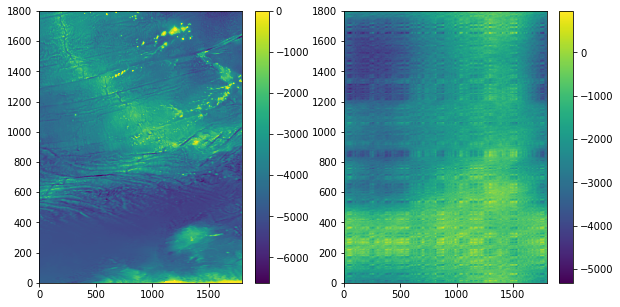

In [85]:
# Plot original and new topography
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
# Original
im=ax[0].pcolormesh(np.real(f))
plt.colorbar(im,ax=ax[0])
# Random
im=ax[1].pcolormesh(-samples[0,:,:])
plt.colorbar(im,ax=ax[1])

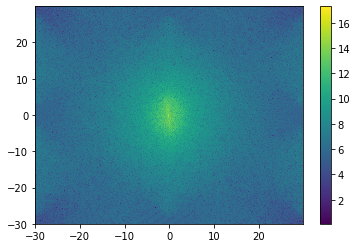

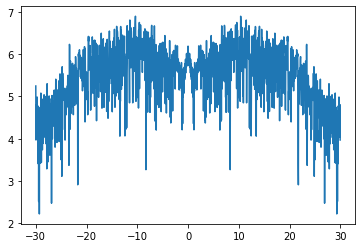

In [32]:
# XRFT
# Perform discrete Fourier transform using xrft
dft = xrft.dft(f,window=True,detrend='constant')
im=plt.pcolormesh(dft.freq_lon,dft.freq_lat,np.log10(np.abs(dft)**2))
plt.colorbar(im)
plt.show()
im=plt.plot(dft.freq_lon,np.log10(np.abs(dft.values[0,:])**2))